In [6]:
import torch
from torch.utils.data import DataLoader
import torchvision
from model import FullModelInCode, FullModelInPaper, FullModel
from dataset import BodyMeasurementDataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

## Load dataset and model

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

training_set = BodyMeasurementDataset("train_female.h5")
training_loader = DataLoader(training_set, batch_size=32, shuffle=True)
validate_set = BodyMeasurementDataset("validate_female.h5")
validate_loader = DataLoader(validate_set, batch_size=16, shuffle=True)
# model_in_code = FullModelInCode()
# model_in_paper = FullModelInPaper()
model = FullModel()

## show samples of dataset

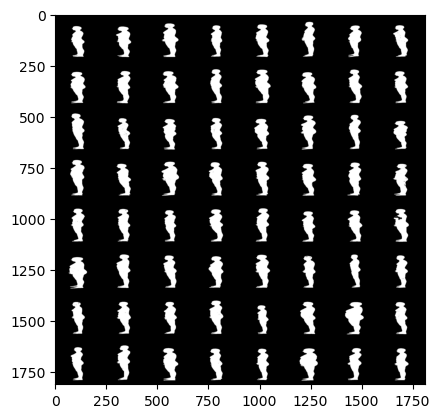

In [8]:
def showimg(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
fronts, sides, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(fronts)
showimg(img_grid)
img_grid = torchvision.utils.make_grid(sides)
showimg(img_grid)

## Train model

In [9]:
def train_one_epoch(model, dataloader, optimizer, device, epoch_index, tb_writer, write_every=5):
    running_loss = 0.0
    all_loss = 0.0
    
    for i, data in tqdm(enumerate(dataloader)):
        fronts, sides, labels = data
        fronts, sides, labels = fronts.to(device), sides.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(fronts, sides)
        loss = torch.nn.functional.mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        all_loss += running_loss
        if i % write_every == write_every - 1:
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', running_loss, tb_x)
            # print('  epoch: {} batch: {} loss: {}'.format(epoch_index, i, running_loss))
    
    return all_loss / len(dataloader)

def train(model, train_dataloader, validate_dataloader, device, write_every=10, epochs=150):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/model_{}'.format(timestamp))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.to(device)
    epoch_number = 0
    best_vloss = 1_000_000.

    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, train_dataloader, optimizer, device, epoch_number, writer)

        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validate_dataloader):
                vfronts, vsides, vlabels = vdata
                vfronts, vsides, vlabels = vfronts.to(device), vsides.to(device), vlabels.to(device)
                voutputs = model(vfronts, vsides)
                vloss = torch.nn.functional.mse_loss(voutputs, vlabels)
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model/model_{}_{}.ckpt'.format(timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

## Train model (from scratch)

In [10]:
train(model, training_loader, validate_loader, device)

EPOCH 1:


26it [00:03,  7.26it/s]


LOSS train 1713978.5165264423 valid 300546.46875
EPOCH 2:


26it [00:03,  8.23it/s]


LOSS train 60359.962101862984 valid 10612.8203125
EPOCH 3:


26it [00:03,  8.27it/s]


LOSS train 6265.672588641827 valid 3766.953857421875
EPOCH 4:


26it [00:03,  8.22it/s]


LOSS train 4474.757774939904 valid 3767.22998046875
EPOCH 5:


26it [00:03,  8.26it/s]


LOSS train 4344.501934344952 valid 3323.873779296875
EPOCH 6:


26it [00:03,  8.22it/s]


LOSS train 4402.894859900842 valid 3344.281494140625
EPOCH 7:


26it [00:03,  8.17it/s]


LOSS train 4422.135667067308 valid 3512.91455078125
EPOCH 8:


26it [00:03,  8.18it/s]


LOSS train 4456.259117713342 valid 3441.825439453125
EPOCH 9:


26it [00:03,  8.21it/s]


LOSS train 4689.928889347957 valid 3403.810546875
EPOCH 10:


26it [00:03,  8.16it/s]


LOSS train 4810.079571063702 valid 3936.567626953125
EPOCH 11:


26it [00:03,  8.15it/s]


LOSS train 4464.1734619140625 valid 3425.813232421875
EPOCH 12:


26it [00:03,  8.17it/s]


LOSS train 4846.988966721755 valid 3232.92578125
EPOCH 13:


26it [00:03,  8.19it/s]


LOSS train 4435.143573467548 valid 3523.39013671875
EPOCH 14:


26it [00:03,  8.18it/s]


LOSS train 4409.498985877404 valid 3533.7724609375
EPOCH 15:


26it [00:03,  8.16it/s]


LOSS train 4751.106727013221 valid 2989.855712890625
EPOCH 16:


26it [00:03,  8.17it/s]


LOSS train 4259.6939697265625 valid 2929.95703125
EPOCH 17:


26it [00:03,  8.11it/s]


LOSS train 4038.695105919471 valid 2976.636962890625
EPOCH 18:


26it [00:03,  8.12it/s]


LOSS train 3793.7691086989184 valid 2479.195556640625
EPOCH 19:


26it [00:03,  8.16it/s]


LOSS train 3615.6361647385816 valid 2304.71630859375
EPOCH 20:


26it [00:03,  8.18it/s]


LOSS train 3265.2718881460337 valid 2214.4267578125
EPOCH 21:


26it [00:03,  8.17it/s]


LOSS train 3024.534142127404 valid 2120.3203125
EPOCH 22:


26it [00:03,  8.10it/s]


LOSS train 3107.1016657902646 valid 2075.239990234375
EPOCH 23:


26it [00:03,  8.20it/s]


LOSS train 3158.2513615534854 valid 2099.553955078125
EPOCH 24:


26it [00:03,  8.11it/s]


LOSS train 2968.094717172476 valid 2364.8623046875
EPOCH 25:


26it [00:03,  8.23it/s]


LOSS train 3054.423396183894 valid 2147.327880859375
EPOCH 26:


26it [00:03,  8.21it/s]


LOSS train 2982.4762432391826 valid 1998.2745361328125
EPOCH 27:


26it [00:03,  8.20it/s]


LOSS train 3097.5962853064902 valid 2856.959716796875
EPOCH 28:


26it [00:03,  8.19it/s]


LOSS train 3138.6075533353364 valid 2100.435546875
EPOCH 29:


26it [00:03,  8.13it/s]


LOSS train 2869.3462759164663 valid 2052.370849609375
EPOCH 30:


26it [00:03,  8.15it/s]


LOSS train 3000.483163686899 valid 2190.891845703125
EPOCH 31:


26it [00:03,  8.20it/s]


LOSS train 2972.267071063702 valid 1985.825927734375
EPOCH 32:


26it [00:03,  8.17it/s]


LOSS train 2976.47900390625 valid 2209.6767578125
EPOCH 33:


26it [00:03,  8.23it/s]


LOSS train 3025.1854060246396 valid 2146.433349609375
EPOCH 34:


26it [00:03,  8.22it/s]


LOSS train 2986.3277963491587 valid 2069.175048828125
EPOCH 35:


26it [00:03,  8.13it/s]


LOSS train 2996.5972712590146 valid 2980.65771484375
EPOCH 36:


26it [00:03,  8.17it/s]


LOSS train 3058.934307391827 valid 2556.90185546875
EPOCH 37:


26it [00:03,  8.21it/s]


LOSS train 2874.3036827674277 valid 2034.4769287109375
EPOCH 38:


26it [00:03,  8.12it/s]


LOSS train 2830.998347355769 valid 3142.29931640625
EPOCH 39:


26it [00:03,  8.10it/s]


LOSS train 3108.0172306941104 valid 2345.904541015625
EPOCH 40:


26it [00:03,  8.20it/s]


LOSS train 2739.9791071965146 valid 1797.447509765625
EPOCH 41:


26it [00:03,  8.21it/s]


LOSS train 2743.196523813101 valid 1820.7332763671875
EPOCH 42:


26it [00:03,  8.23it/s]


LOSS train 2790.8573091947114 valid 1987.3839111328125
EPOCH 43:


26it [00:03,  8.15it/s]


LOSS train 2708.9856238731973 valid 1791.34716796875
EPOCH 44:


26it [00:03,  8.15it/s]


LOSS train 2513.6907489483174 valid 1795.280029296875
EPOCH 45:


26it [00:03,  8.19it/s]


LOSS train 2398.397869403546 valid 1672.1256103515625
EPOCH 46:


26it [00:03,  8.22it/s]


LOSS train 2397.3809251051684 valid 1676.3228759765625
EPOCH 47:


26it [00:03,  8.19it/s]


LOSS train 2238.4393780048076 valid 1460.0706787109375
EPOCH 48:


26it [00:03,  8.14it/s]


LOSS train 2313.339148888221 valid 1340.71044921875
EPOCH 49:


26it [00:03,  8.19it/s]


LOSS train 2242.787029559796 valid 1352.3890380859375
EPOCH 50:


26it [00:03,  8.24it/s]


LOSS train 2153.7645404522236 valid 1360.05078125
EPOCH 51:


26it [00:03,  8.27it/s]


LOSS train 2270.373553936298 valid 1438.9715576171875
EPOCH 52:


16it [00:01,  8.11it/s]

## Train model replicated from code (from scratch)

## Train model replicated from paper (from scratch)